In [5]:
working_dir = '/mnt/c/users/fordd/Downloads/RW_PGM_FE/'
py_files_dir =  working_dir+'py_files/'
saved_arrays_dir = working_dir+'saved_arrays/'
saved_models_dir = working_dir+'saved_models/'

In [6]:
import os

os.chdir(py_files_dir)

from utils import *

os.chdir(working_dir)

In [7]:
import matplotlib as mpl
#mpl.rc('xtick', labelsize=11) 
#mpl.rc('ytick', labelsize=11) 

In [8]:
from pymbar import MBAR

In [9]:
delta_f_ground_truth = np.array([0.        , 1.99260131])
delta_f_ground_truth = np.array([0.0242205 , 0.00768604, 0.01645141, 
                                 0.        , 1.31893825, 1.30793731])

In [11]:
estimates, grid, AVMD_f_T_all, AVMD_S_T_all =  load_pickle_(saved_arrays_dir+'IB300u_est_grid_AVall_I6W_II')

av_u_T = estimates[:,:,8].mean(1)
av_u_T -= av_u_T.min()
av_u_V = estimates[:,:,9].mean(1)
av_u_V -= av_u_V.min()
av_u_GT = (av_u_V+av_u_T)*0.5
av_u_GT -= av_u_GT.min()

av_u_GT 

array([0.08293272, 0.06002475, 0.04113775, 0.        , 0.58077775,
       0.672297  ])

In [14]:
name_save_BAR_inputs = saved_arrays_dir+'IB300u_BAR_inputs_I6W_II'
name_save_mBAR_inputs = saved_arrays_dir+'IB300u_MBAR_inputs_I6W_II'
n_states = 6

# Obtaining mBAR results using pymbar:

In [15]:
state_min = 0

estimates_MBAR = np.zeros([4, grid.shape[0], n_states])

for i in range(grid.shape[0]):
    clear_output(wait=True) ; print(i)
    name = name_save_mBAR_inputs+'_PHIij_T_'+str(i)
    x = load_pickle_(name)+200. ; m = x.shape[-1]
    try:
        mbar_res = MBAR(x.reshape(n_states,n_states*m), np.array([m]*n_states)).compute_free_energy_differences()
        FE = mbar_res['Delta_f'][state_min]
        SD = mbar_res['dDelta_f'][state_min]
    except:
        FE = -1. ; SD = 0
    estimates_MBAR[0,i,:] = FE
    estimates_MBAR[1,i,:] = SD
    
    name = name_save_mBAR_inputs+'_PHIij_V_'+str(i)
    x = load_pickle_(name)+200. ; m = x.shape[-1]
    try:
        mbar_res = MBAR(x.reshape(n_states,n_states*m), np.array([m]*n_states)).compute_free_energy_differences()
        FE = mbar_res['Delta_f'][state_min]
        SD = mbar_res['dDelta_f'][state_min]
    except:
        FE = -1. ; SD = 0
    estimates_MBAR[2,i,:] = FE
    estimates_MBAR[3,i,:] = SD
    
estimates_MBAR = np.where(np.isnan(estimates_MBAR),0.0,estimates_MBAR)

99


# Obtaining BAR results using pymbar:

In [16]:
estimates_BAR = np.zeros([4, grid.shape[0], n_states])
offset = 333.0 # potential energies x[0] should be simular to entropy estimates x[1]

for i in range(grid.shape[0]):
    clear_output(wait=True)
    print(i)
    for k in range(n_states):
        name = name_save_BAR_inputs+'_BAR_input_'+str(i)+'_state'+str(k)+'_'+'_T'
        x = load_pickle_(name) ; m = x.shape[-1]//2
        try:
            mbar_res = MBAR(np.stack([
                    x[0] - offset,
                    x[1],
                ],axis=0), np.array([m]*2)).compute_free_energy_differences()
            FE = mbar_res['Delta_f'][1,0] + offset
            SD = mbar_res['dDelta_f'][1,0]
        except:
            FE = -1. ; SD = 0
        estimates_BAR[0,i,k] = FE
        estimates_BAR[1,i,k] = SD
        
        name = name_save_BAR_inputs+'_BAR_input_'+str(i)+'_state'+str(k)+'_'+'_V'
        x = load_pickle_(name) ; m = x.shape[-1]//2
        try:
            mbar_res = MBAR(np.stack([
                    x[0] - offset,
                    x[1],
                ],axis=0), np.array([m]*2)).compute_free_energy_differences()
            FE = mbar_res['Delta_f'][1,0] + offset
            SD = mbar_res['dDelta_f'][1,0]
        except:
            FE = -1. ; SD = 0
        estimates_BAR[2,i,k] = FE
        estimates_BAR[3,i,k] = SD
        
estimates_BAR = np.where(np.isnan(estimates_BAR),0.0,estimates_BAR)

99


In [17]:
i=k=0
name = name_save_BAR_inputs+'_BAR_input_'+str(i)+'_state'+str(k)+'_'+'_T'
x = load_pickle_(name) ; m = x.shape[-1]//2

MD_energies_T = np.zeros([n_states, grid.shape[0], m])
MD_energies_V = np.zeros([n_states, grid.shape[0], m])
BG_energies = np.zeros([n_states, grid.shape[0], m])
BG_f = np.zeros([n_states, grid.shape[0], m])

for i in range(grid.shape[0]):
    clear_output(wait=True)
    print(i)
    for k in range(n_states):
        name = name_save_BAR_inputs+'_BAR_input_'+str(i)+'_state'+str(k)+'_'+'_T'
        x = load_pickle_(name) ; m = x.shape[-1]//2
        BG_energies[k,i] = x[0,m:]
        MD_energies_T[k,i] = x[0,:m]
        BG_f[k,i] = x[0,m:] - x[1,m:]
        ##
        name = name_save_BAR_inputs+'_BAR_input_'+str(i)+'_state'+str(k)+'_'+'_V'
        x = load_pickle_(name) ; m = x.shape[-1]//2
        MD_energies_V[k,i] = x[0,:m]

99


In [18]:
less100_mask = np.where(BG_energies<100,1,0)
av_BG = (less100_mask*BG_f).sum(-1) / less100_mask.sum(-1) 

In [19]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=11) 
mpl.rc('ytick', labelsize=11) 
plt.style.use('classic')
%matplotlib inline
fontname = 'Times New Roman'
plt.rcParams["font.family"] = fontname
plt.rcParams['font.size'] = 15
default_colours = [
'#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

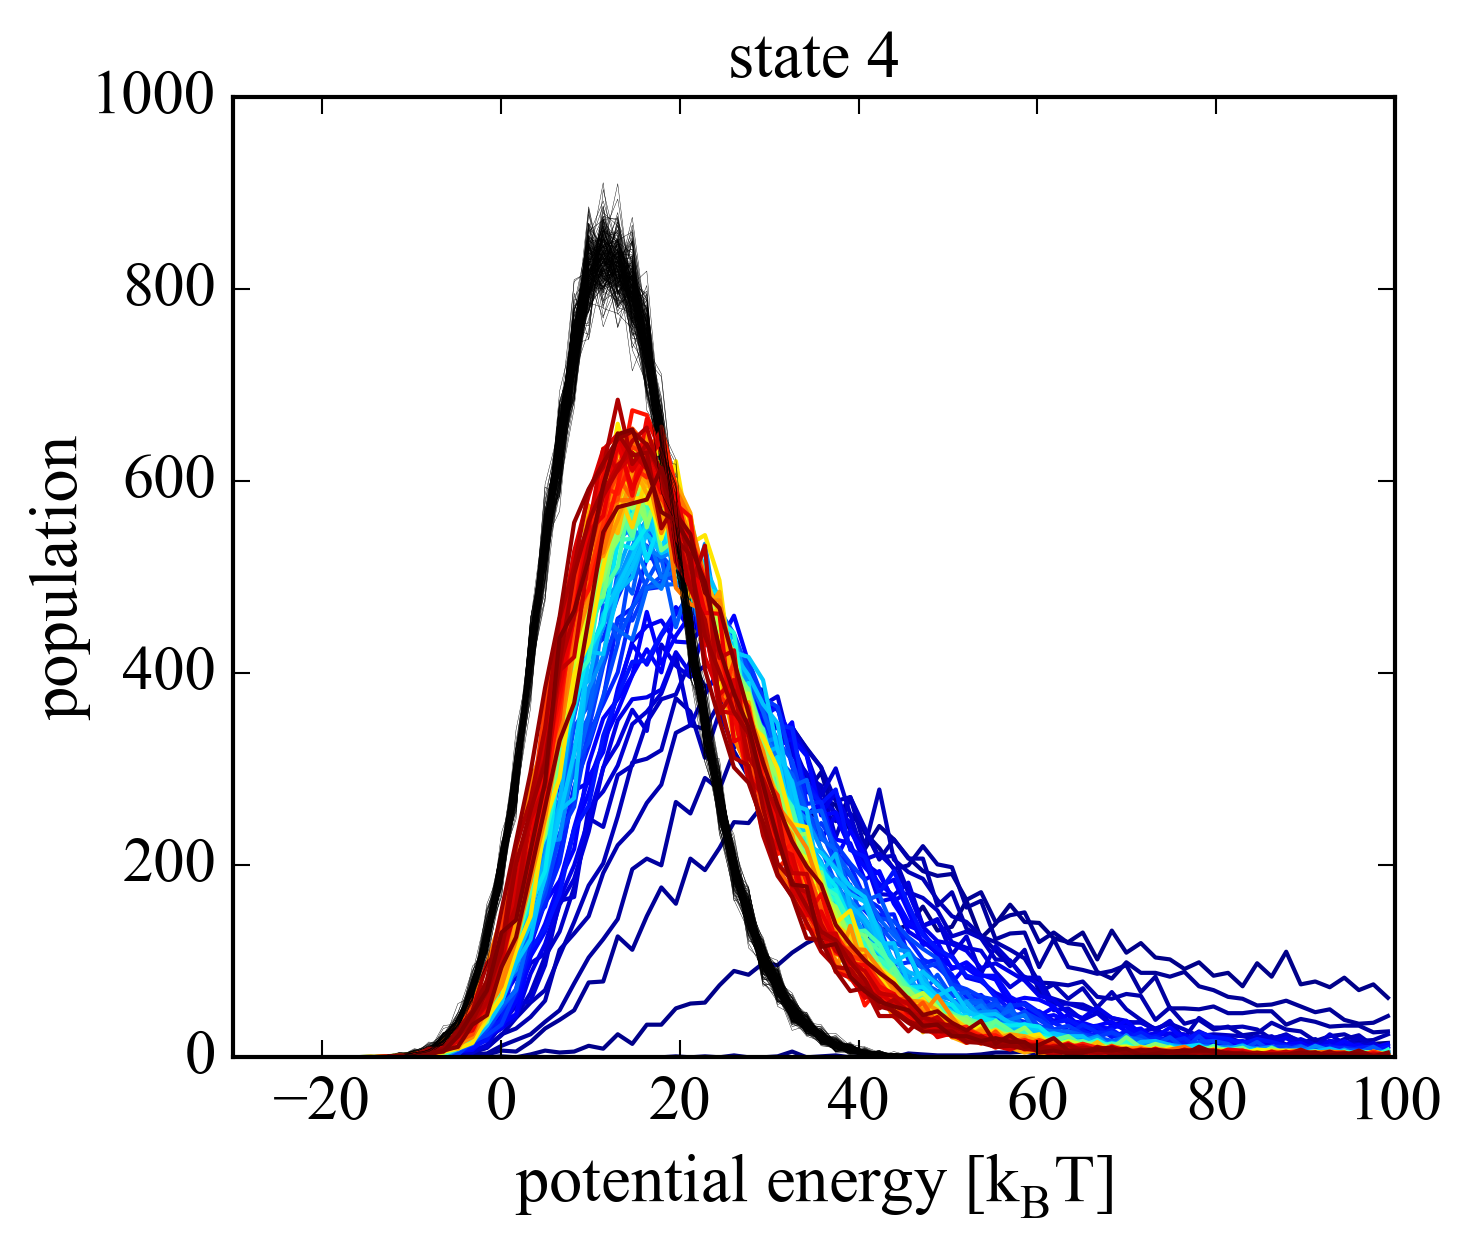

In [104]:
state = 4

n_bins = 80 ; density = False
a = -30
b = 100
axis = np.linspace(a,b,n_bins+1)
axis = axis[1:] - 0.5*(axis[1]-axis[0])

colors = plt.cm.jet(np.linspace(0,1,grid.shape[0]))
custom_cmap = mpl.colors.ListedColormap(colors)

fig = plt.figure(figsize=(5,4),dpi=300, facecolor="white")

for i in range(grid.shape[0]):
    plt.plot(axis,
             np.histogram(BG_energies[state,i],range=[a,b],bins=n_bins,density=density)[0],
             color=custom_cmap.colors[i])
    
    plt.plot(axis,
             np.histogram(MD_energies_T[state,i],range=[a,b],bins=n_bins,density=density)[0],
             color='black',linewidth=0.1)
    plt.plot(axis,
             np.histogram(MD_energies_V[state,i],range=[a,b],bins=n_bins,density=density)[0],
             color='black',linewidth=0.1)
plt.title('state '+str(state), size=16)
plt.ylim(0,1000)
plt.xlim(a,b)
plt.xlabel('potential energy [$\mathregular{k_B}$T]', size=16)
plt.ylabel('population', labelpad=0, size=16)
plt.show()

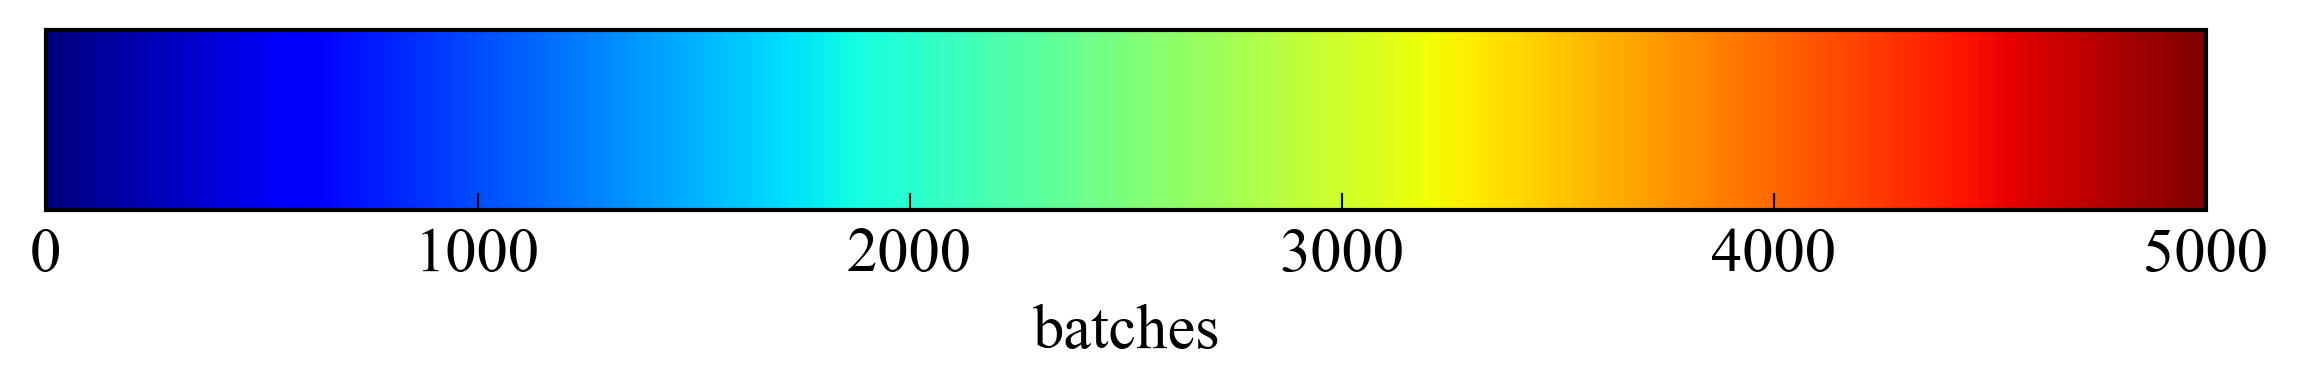

In [21]:
fig = plt.figure(dpi=300, facecolor="white")
cb = mpl.colorbar.ColorbarBase(fig.add_axes([0.05, 0.80, 0.9, 0.1]),
                               orientation='horizontal', 
                               cmap='jet',
                               norm=mpl.colors.Normalize(0, 5000),  # vmax and vmin
                               #extend='both',
                               label='batches',
                               ticks=[0, 1000, 2000, 3000, 4000, 5000])

In [22]:
plt.rcParams['font.size'] = 14

(0.0, 5000.0)

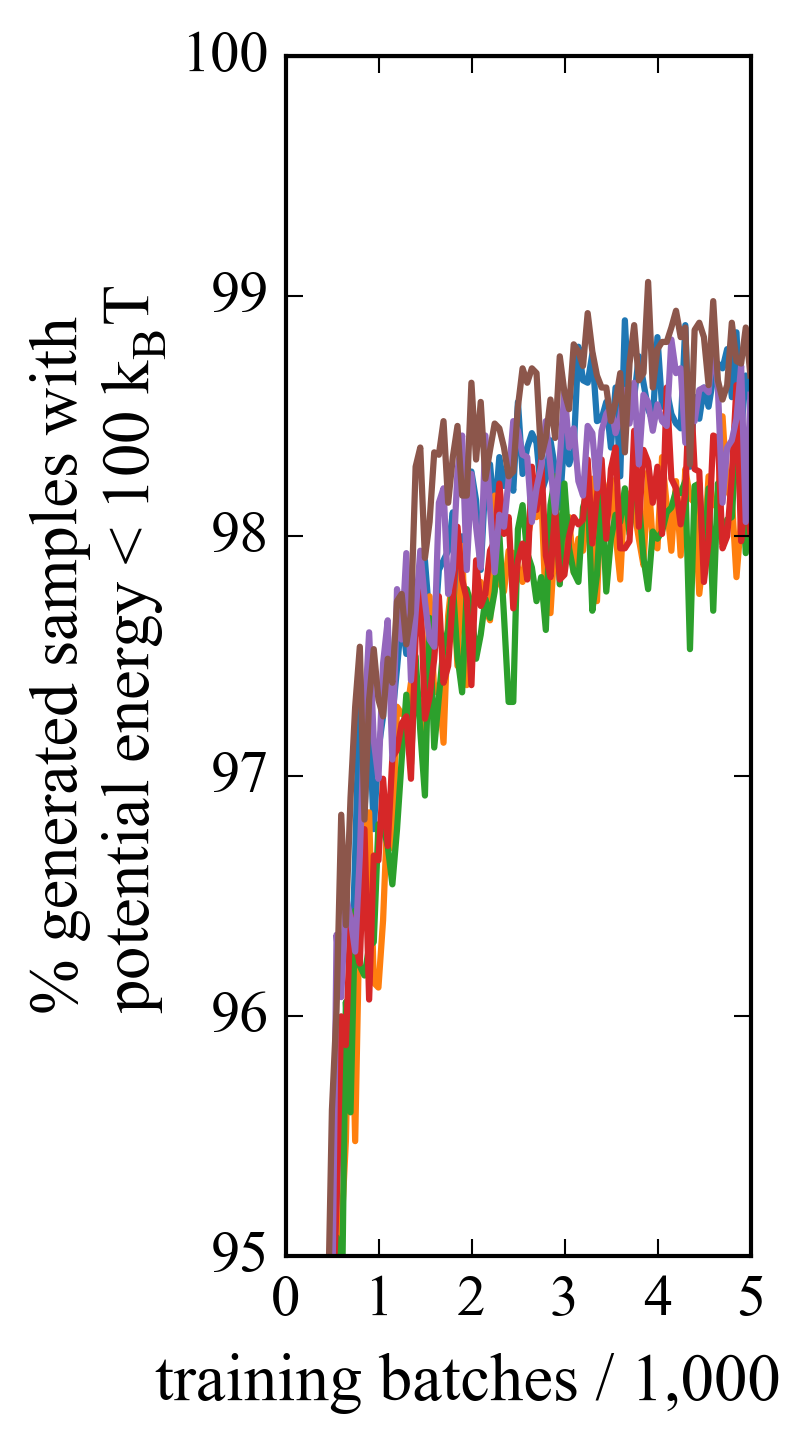

In [23]:
less100_mask = np.where(BG_energies<100,1,0)
av_BG = (less100_mask*BG_f).sum(-1) / less100_mask.sum(-1)

fig = plt.figure(figsize=(2,5),dpi=300, facecolor="white")
for k in range(n_states):
    plt.plot(grid,100*less100_mask.sum(-1)[k]/m,color=default_colours[k],
            linewidth=1.5) 

plt.plot([0,3000],[100]*2,color='black')
plt.xticks([0,1000,2000,3000,4000,5000],[0,1,2,3,4,5])
plt.yticks([95,96,97,98,99,100],[95,96,97,98,99,100])
plt.xlabel('training batches / 1,000      ', size=16, labelpad=6)
plt.ylabel('% generated samples with \n potential energy < 100 $\mathregular{k_B}$T',
           labelpad=3, size=16)
plt.ylim(95,100)
plt.xlim(0,5000)

3


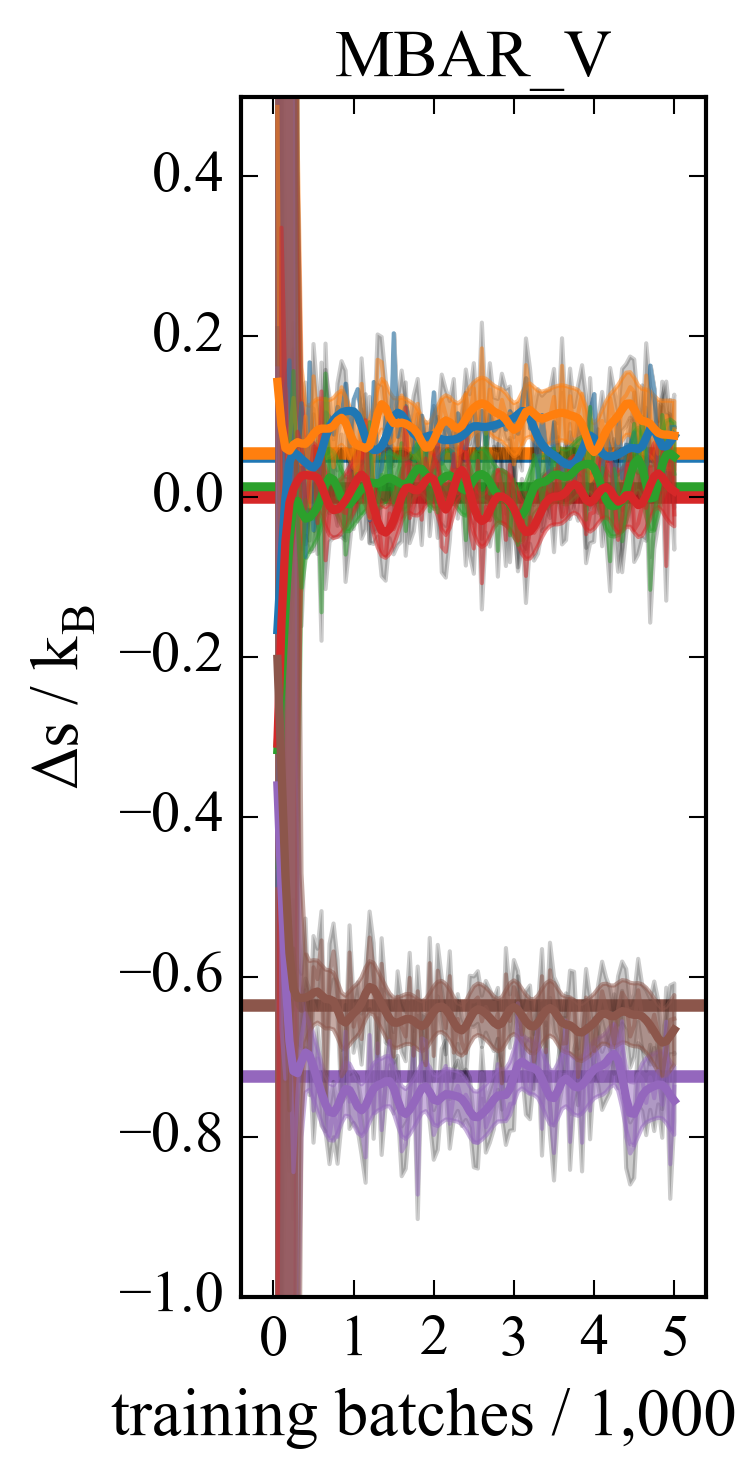

In [24]:
ind_min = np.argmin(delta_f_ground_truth)
print(ind_min)

# selecting which result to plot:
name = 'MBAR_V'#5

av_u_GT = (estimates[:,:,8].mean(1) + estimates[:,:,8].mean(1))*0.5
negS_GT = np.array(delta_f_ground_truth-av_u_GT)
negS_GT  -= negS_GT[ind_min]

if type(name) is int:
    start =  20 #135
    end = 30
    x = fs_to_deltafs_(-(estimates[:,:,name].T - av_u_GT), ind_min=ind_min, start=start, median=True) # (m,n_states)
    xL = x - np.nan
    xU = x + np.nan
    if name == 0: name = 'AVMD_T'
    elif name == 1: name = 'AVMD_V'
    elif name == 2:
        name = 'AVBG'
        x = fs_to_deltafs_(-(np.array(av_BG.T) - av_u_GT), ind_min=ind_min, start=start)
        xL = x - np.nan
        xU = x + np.nan
    elif name == 3: name = 'EXPMD_T'
    elif name == 4: name = 'EXPMD_V'
    elif name == 5: name = 'EXPBG'
    elif name == 6: name = 'BAR_T(local)'
    elif name == 7: name = 'BAR_V(local)'
    else: print('not')
else: pass

if type(name) is str and 'BAR' in name and 'M' not in name:
    start = 10
    end = 20
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_BAR[which] - av_u_GT), ind_min=ind_min, start=start, end=end) # (m,n_states)
    xL = x - estimates_BAR[which+1]
    xU = x + estimates_BAR[which+1]
else: pass

if type(name) is str and 'MBAR' in name:
    start = 5
    end = 1000000 # 10
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_MBAR[which] - av_u_GT), ind_min=ind_min, start=start, end=end) # (m,n_states)
    xL = x - estimates_MBAR[which+1]
    xU = x + estimates_MBAR[which+1]
else: pass

fig = plt.figure(figsize=(2,5),dpi=300, facecolor="white")
[plt.plot([-400,grid[-1]+400],[-negS_GT[k]]*2, color=default_colours[k], linewidth=3, zorder=-10) for k in range(n_states)]

[plt.plot(grid, x[:,k], color=default_colours[k], alpha=0.5, linewidth=1) for k in range(n_states)]

[plt.fill_between(grid,
                 xL[:,k],
                 xU[:,k],
                 alpha=0.2,
                 color='black',
                
                ) for k in range(n_states)]
[plt.fill_between(grid,
                 simple_smoother_(xL[:,k],c=0.6),
                 simple_smoother_(xU[:,k],c=0.6),
                 alpha=0.5,
                 color=default_colours[k],
                
                ) for k in range(n_states)]

[plt.plot(grid, simple_smoother_(x[:,k],c=0.6), color=default_colours[k], linewidth=2) for k in range(n_states)]

plt.title(name, size=16)
plt.ylim(-1.0,0.5)
plt.xticks([0,1000,2000,3000,4000,5000],[0,1,2,3,4,5])
plt.xlim(-400.0,5400)
plt.xlabel('training batches / 1,000      ', size=16)
plt.ylabel('Δs / $\mathregular{k_B}$', labelpad=5, size=16)
plt.show()

3


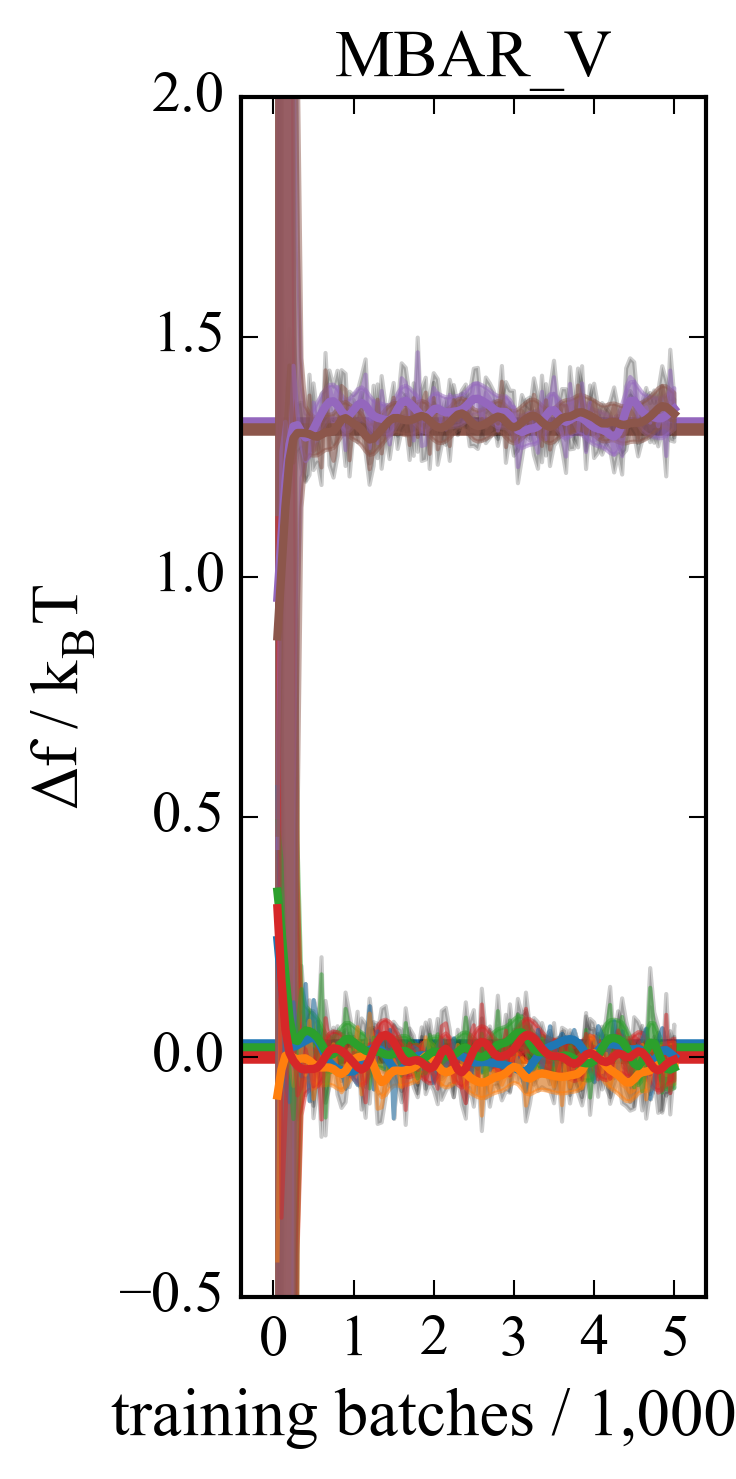

In [26]:
ind_min = np.argmin(delta_f_ground_truth)
print(ind_min)

name = 'MBAR_V'#5

if type(name) is int:
    start =  20 #135
    end = 30
    x = fs_to_deltafs_(estimates[:,:,name].T, ind_min=ind_min, start=start, median=True) # (m,n_states)
    xL = x - np.nan
    xU = x + np.nan
    if name == 0: name = 'AVMD_T'
    elif name == 1: name = 'AVMD_V'
    elif name == 2:
        name = 'AVBG'
        x = fs_to_deltafs_(np.array(av_BG.T), ind_min=ind_min, start=start)
        xL = x - np.nan
        xU = x + np.nan
    elif name == 3: name = 'EXPMD_T'
    elif name == 4: name = 'EXPMD_V'
    elif name == 5: name = 'EXPBG'
    elif name == 6: name = 'BAR_T(local)'
    elif name == 7: name = 'BAR_V(local)'
    else: print('not')
else: pass

if type(name) is str and 'BAR' in name and 'M' not in name:
    start = 10
    end = 20
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(estimates_BAR[which], ind_min=ind_min, start=start, end=end) # (m,n_states)
    xL = x - estimates_BAR[which+1]
    xU = x + estimates_BAR[which+1]
else: pass

if type(name) is str and 'MBAR' in name:
    start = 5
    end = 10000 # 10
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(estimates_MBAR[which], ind_min=ind_min, start=start, end=end) # (m,n_states)
    xL = x - estimates_MBAR[which+1]
    xU = x + estimates_MBAR[which+1]
else: pass
#x-= 0.5
fig = plt.figure(figsize=(2,5),dpi=300, facecolor="white")
[plt.plot([-400,grid[-1]+400],[delta_f_ground_truth[k]]*2, color=default_colours[k], linewidth=3, zorder=-10) for k in range(n_states)]

[plt.plot(grid, x[:,k], color=default_colours[k], alpha=0.5, linewidth=1) for k in range(n_states)]

[plt.fill_between(grid,
                 xL[:,k],
                 xU[:,k],
                 alpha=0.2,
                 color='black',
                
                ) for k in range(n_states)]
[plt.fill_between(grid,
                 simple_smoother_(xL[:,k],c=0.6),
                 simple_smoother_(xU[:,k],c=0.6),
                 alpha=0.5,
                 color=default_colours[k],
                
                ) for k in range(n_states)]

[plt.plot(grid, simple_smoother_(x[:,k],c=0.6), color=default_colours[k], linewidth=2) for k in range(n_states)]

plt.title(name, size=16)
plt.ylim(-0.5,2.0)
plt.xticks([0,1000,2000,3000,4000,5000],[0,1,2,3,4,5])
plt.xlim(-400.0,5400)
plt.xlabel('training batches / 1,000      ', size=16)
plt.ylabel('Δf / $\mathregular{k_B}$T', labelpad=5, size=16)
plt.show()

(-1.0, 2.0)

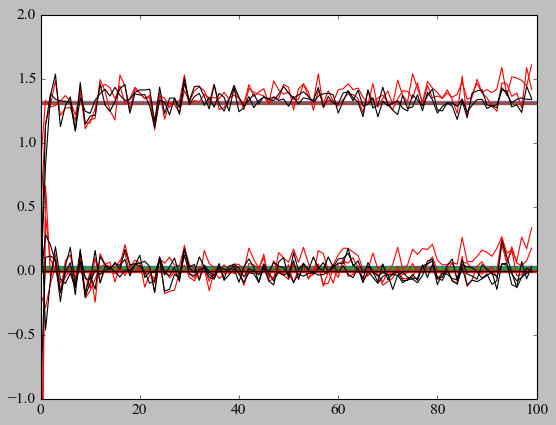

In [146]:
plt.plot(estimates_MBAR[0],color='red')
plt.plot(estimates_MBAR[-2],color='black')
[plt.plot([0,100],[delta_f_ground_truth[k]]*2, color=default_colours[k], linewidth=3, zorder=-10) for k in range(n_states)]

plt.ylim(-1,2)

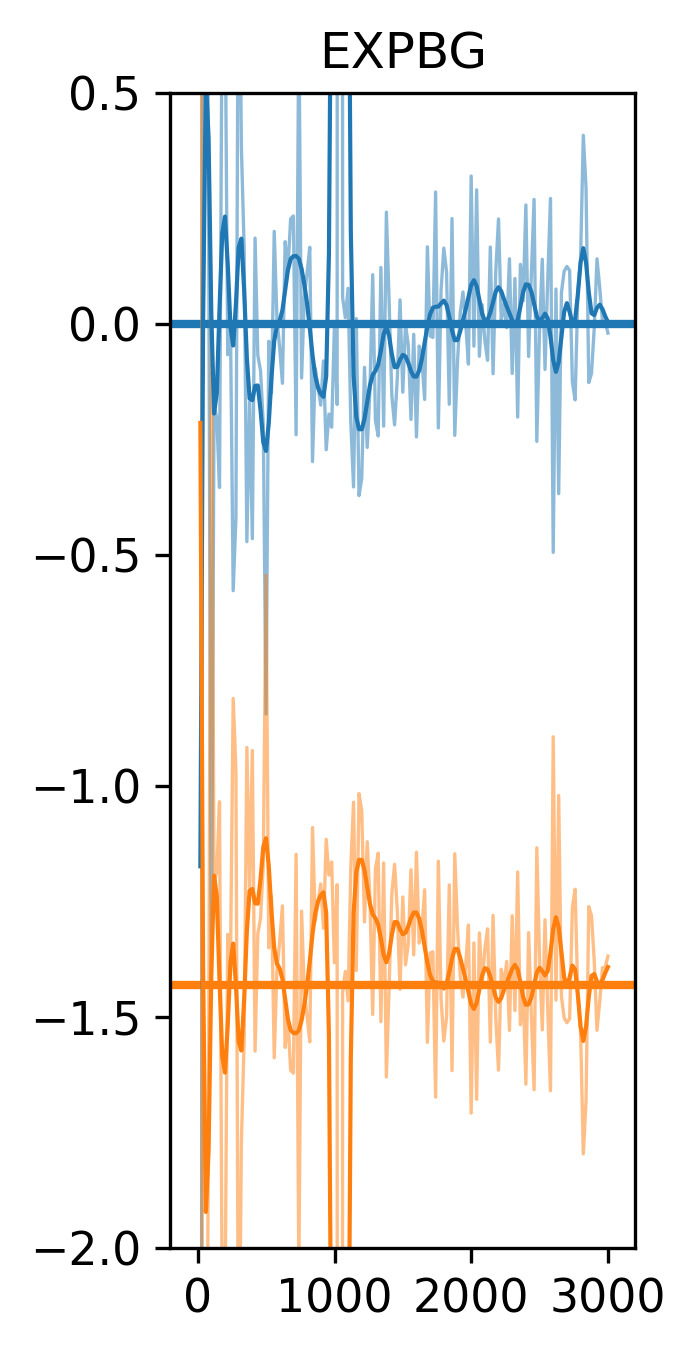

In [48]:
ind_min = 0

name = 5

av_u_GT = (estimates[:,:,8].mean(1) + estimates[:,:,8].mean(1))*0.5
negS_GT = np.array(delta_f_ground_truth-av_u_GT)
negS_GT  -= negS_GT[ind_min]

if type(name) is int:
    start =  50 #135
    x = fs_to_deltafs_(-(estimates[:,:,name].T - av_u_GT), ind_min=ind_min, start=start, median=True) # (m,n_states)
    xL = x - np.nan
    xU = x + np.nan
    if name == 0: name = 'AVMD_T'
    elif name == 1: name = 'AVMD_V'
    elif name == 2:
        name = 'AVBG'
        x = fs_to_deltafs_(-(np.array(av_BG.T) - av_u_GT), ind_min=ind_min, start=start)
        xL = x - np.nan
        xU = x + np.nan
    elif name == 3: name = 'EXPMD_T'
    elif name == 4: name = 'EXPMD_V'
    elif name == 5: name = 'EXPBG'
    elif name == 6: name = 'BAR_T(local)'
    elif name == 7: name = 'BAR_V(local)'
    else: print('not')
else: pass

if type(name) is str and 'BAR' in name and 'M' not in name:
    start = 50 #100
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_BAR[which] - av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - estimates_BAR[which+1]
    xU = x + estimates_BAR[which+1]
else: pass

if type(name) is str and 'MBAR' in name:
    start = 50 #100
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_MBAR[which] - av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - estimates_MBAR[which+1]
    xU = x + estimates_MBAR[which+1]
else: pass
#x-= 0.5
fig = plt.figure(figsize=(2,5),dpi=300)
[plt.plot([-400,grid[-1]+400],[-negS_GT[k]]*2, color='C'+str(k), linewidth=2, zorder=-10) for k in range(n_states)]


[plt.plot(grid, x[:,k], color='C'+str(k), alpha=0.5, linewidth=0.8) for k in range(n_states)]

[plt.fill_between(grid,
                 xL[:,k],
                 xU[:,k],
                 alpha=0.2,
                 color='black',
                
                ) for k in range(n_states)]
[plt.fill_between(grid,
                 simple_smoother_(xL[:,k],c=0.6),
                 simple_smoother_(xU[:,k],c=0.6),
                 alpha=0.5,
                 color='C'+str(k),
                
                ) for k in range(n_states)]

[plt.plot(grid, simple_smoother_(x[:,k],c=0.6), 'C'+str(k), linewidth=1) for k in range(n_states)]

plt.title(name)
plt.ylim(-2.0,0.5)
plt.xticks([0,1000,2000,3000])
plt.xlim(-200.0,3200)
plt.show()

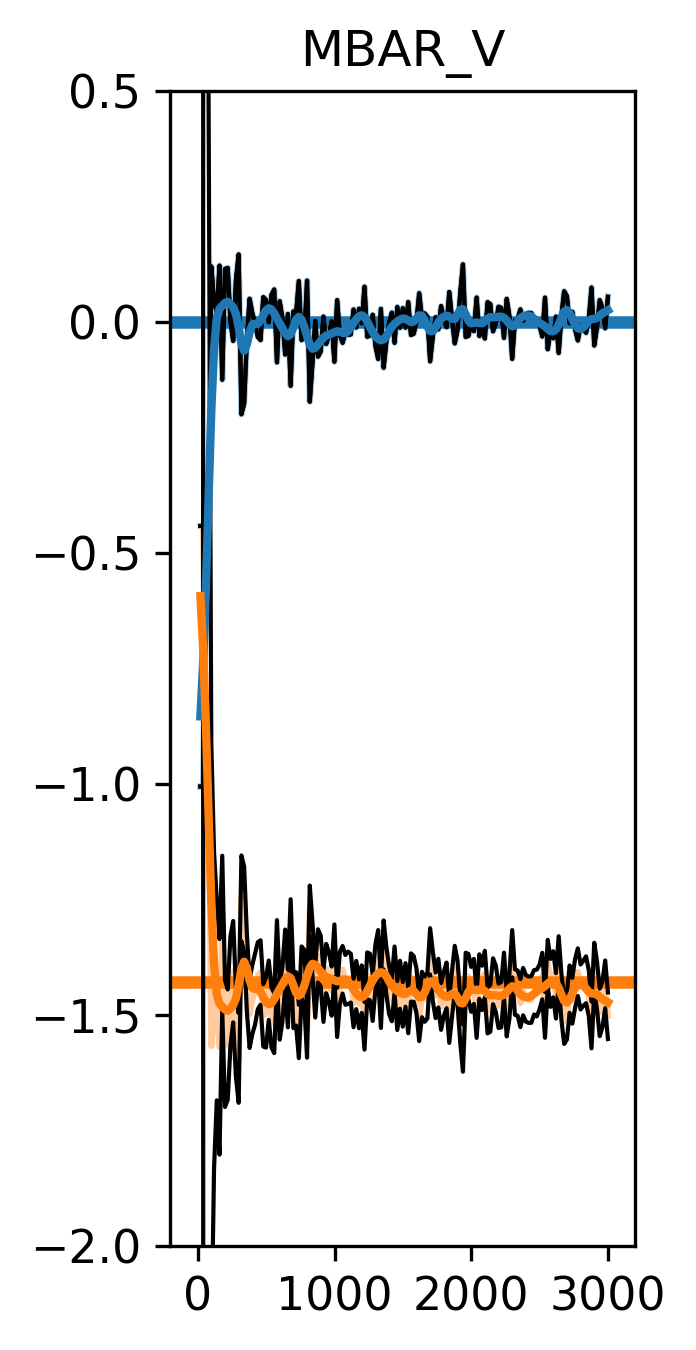

In [18]:
ind_min = 0

name = 'MBAR_V'

negS_GT = np.array(delta_f_ground_truth-av_u_GT)
negS_GT  -= negS_GT[ind_min]

if type(name) is int:
    start = 50
    x = fs_to_deltafs_(-(estimates[:,:,name].T - av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - np.nan
    xU = x + np.nan
    if name == 0: _name = 'AVMD_T'
    elif name == 1: _name = 'AVMD_V'
    elif name == 2: _name = 'AVBG'
    elif name == 3: _name = 'EXPMD_T'
    elif name == 4: _name = 'EXPMD_V'
    elif name == 5: _name = 'EXPBG'
    elif name == 6: _name = 'BAR_T(local)'
    elif name == 7: _name = 'BAR_V(local)'
    else: print('not')
else: pass

if type(name) is str and 'BAR' in name and 'M' not in name:
    start = 50
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_BAR[which] - av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - estimates_BAR[which+1]
    xU = x + estimates_BAR[which+1]
    _name = name
else: pass

if type(name) is str and 'MBAR' in name:
    start = 50
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_MBAR[which] - av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - estimates_MBAR[which+1]
    xU = x + estimates_MBAR[which+1]
    _name = name
else: pass
#x-= 0.5
fig = plt.figure(figsize=(2,5),dpi=300)
[plt.plot([-200,grid[-1]+200],[-negS_GT[k]]*2, color='C'+str(k), linewidth=3) for k in range(n_states)]

[plt.plot(grid, x[:,k], color='C'+str(k), alpha=0.4) for k in range(n_states)]
[plt.plot(grid, xL[:,k], color='black', alpha=1, linewidth=1) for k in range(n_states)]
[plt.plot(grid, xU[:,k], color='black', alpha=1, linewidth=1) for k in range(n_states)]

[plt.plot(grid, simple_smoother_(x[:,k],c=0.6), 'C'+str(k), linewidth=2) for k in range(n_states)]

plt.title(_name)
plt.ylim(-2.0,0.5)
plt.xticks([0,1000,2000,3000])
plt.xlim(-200.0,3200)
plt.show()

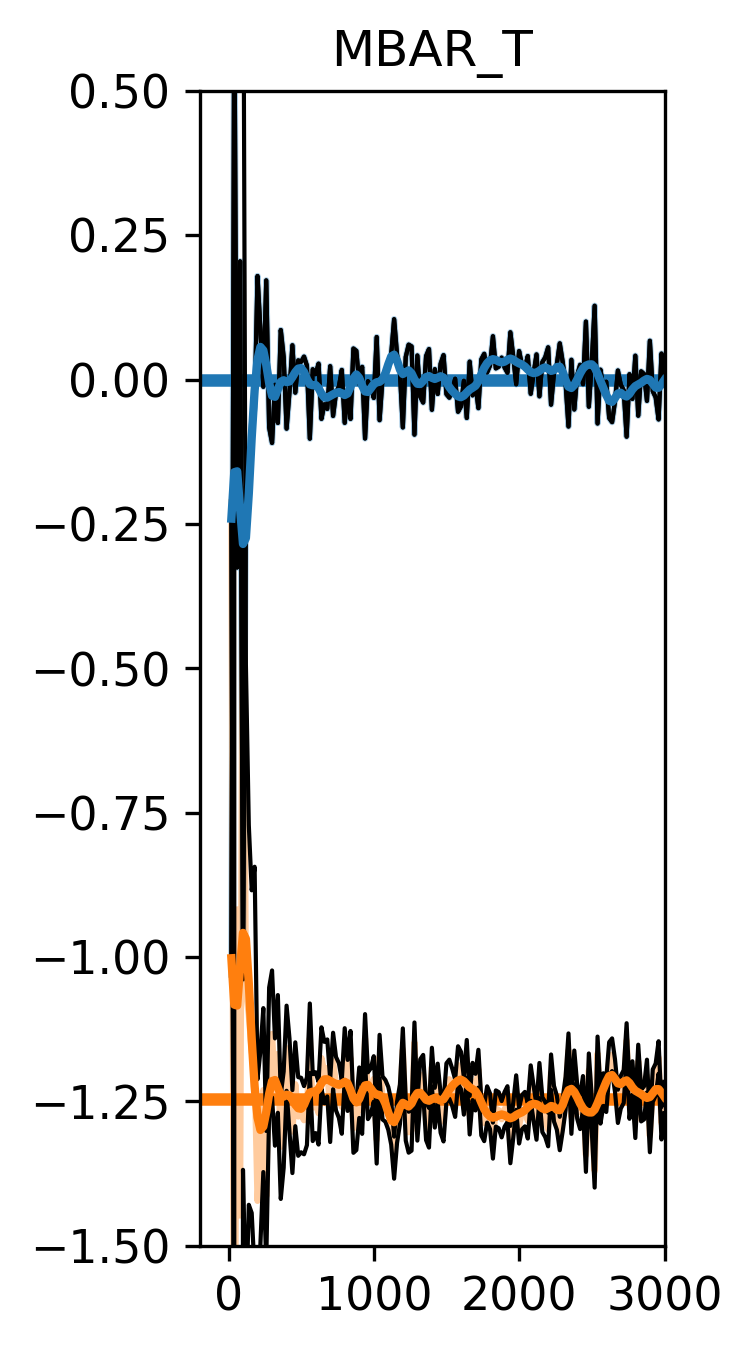

In [156]:
ind_min = 0

name = 'MBAR_T'

negS_GT = np.array(delta_f_ground_truth-av_u_GT0)
negS_GT  -= negS_GT[ind_min]

if type(name) is int:
    start = 139
    x = fs_to_deltafs_(-(estimates[:,:,name].T - 2*av_u_GT0 + av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - np.nan
    xU = x + np.nan
    if name == 0: _name = 'AVMD_T'
    elif name == 1: _name = 'AVMD_V'
    elif name == 2: _name = 'AVBG'
    elif name == 3: _name = 'EXPMD_T'
    elif name == 4: _name = 'EXPMD_V'
    elif name == 5: _name = 'EXPBG'
    elif name == 6: _name = 'BAR_T(local)'
    elif name == 7: _name = 'BAR_V(local)'
    else: print('not')
else: pass

if type(name) is str and 'BAR' in name and 'M' not in name:
    start = 100
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_BAR[which] - 2*av_u_GT0 + av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - estimates_BAR[which+1]
    xU = x + estimates_BAR[which+1]
    _name = name
else: pass

if type(name) is str and 'MBAR' in name:
    start = 100
    if 'V' in name: which = 2
    else: which  = 0
    x = fs_to_deltafs_(-(estimates_MBAR[which] - 2*av_u_GT0 + av_u_GT), ind_min=ind_min, start=start) # (m,n_states)
    xL = x - estimates_MBAR[which+1]
    xU = x + estimates_MBAR[which+1]
    _name = name
else: pass
#x-= 0.5
fig = plt.figure(figsize=(2,5),dpi=300)
[plt.plot([-200,grid[-1]],[-negS_GT[k]]*2, color='C'+str(k), linewidth=3) for k in range(n_states)]

[plt.plot(grid, x[:,k], color='C'+str(k), alpha=0.4) for k in range(n_states)]
[plt.plot(grid, xL[:,k], color='black', alpha=1, linewidth=1) for k in range(n_states)]
[plt.plot(grid, xU[:,k], color='black', alpha=1, linewidth=1) for k in range(n_states)]

[plt.plot(grid, simple_smoother_(x[:,k],c=0.6), 'C'+str(k), linewidth=2) for k in range(n_states)]

plt.title(_name)
plt.ylim(-1.5,0.5)
plt.xticks([0,1000,2000,3000])
plt.xlim(-200.0,3000)
plt.show()